In [5]:
%conda install seaborn

Channels:
 - defaults
 - conda-forge
 - nvidia
 - pytorch
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: c:\Users\lucas\anaconda3\envs\conda1

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.0.9               |       h2bbff1b_8          19 KB
    brotli-bin-1.0.9           |       h2bbff1b_8          29 KB
    contourpy-1.3.1            |  py310h214f63a_0         217 KB
    cycler-0.11.0              |     pyhd3eb1b0_0          12 KB
    fonttools-4.51.0           |  py310h2bbff1b_0         2.0 MB
    kiwisolver-1.4.4           |  py310hd77b12b_0          60 KB
    libbrotlicommon-1.0.9      |       h2bbff1b_8          79 KB
    libbrotlidec-1.0.9         |       h2bbff1b_8          39 KB
    libbrotlienc-1.0.9         |       h2bbff1b_8         261 KB
    matplotlib-base-3.9.2      |

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, GRU, Dropout

In [3]:
tr_df = pd.read_csv('train.csv')

In [4]:
tr_df.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


In [5]:
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         230090 non-null  object
 1   store        230090 non-null  int64 
 2   product      230090 non-null  int64 
 3   number_sold  230090 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB


In [6]:
tr_df['Date'] = pd.to_datetime(tr_df['Date'])

In [7]:
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         230090 non-null  datetime64[ns]
 1   store        230090 non-null  int64         
 2   product      230090 non-null  int64         
 3   number_sold  230090 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 7.0 MB


In [8]:
tr_df['store'].value_counts()

store
0    32870
1    32870
2    32870
3    32870
4    32870
5    32870
6    32870
Name: count, dtype: int64

In [9]:
tr_df['product'].value_counts()

product
0    23009
1    23009
2    23009
3    23009
4    23009
5    23009
6    23009
7    23009
8    23009
9    23009
Name: count, dtype: int64

## We will deal with each store indivedually

# Store 1

In [9]:
tr_df.set_index('Date', inplace= True)

In [10]:
tr_df

,store,product,number_sold
Date,,,
2010-01-01,0,0,801
2010-01-02,0,0,810
2010-01-03,0,0,818
2010-01-04,0,0,796
2010-01-05,0,0,808
...,...,...,...
2018-12-27,6,9,890
2018-12-28,6,9,892
2018-12-29,6,9,895


## 1st Product

In [11]:
# Store 1 with product 1
s1p1 = tr_df[(tr_df['store'] == 0) & (tr_df['product'] == 0)]
s1p1

,store,product,number_sold
Date,,,
2010-01-01,0,0,801
2010-01-02,0,0,810
2010-01-03,0,0,818
2010-01-04,0,0,796
2010-01-05,0,0,808
...,...,...,...
2018-12-27,0,0,847
2018-12-28,0,0,854
2018-12-29,0,0,839


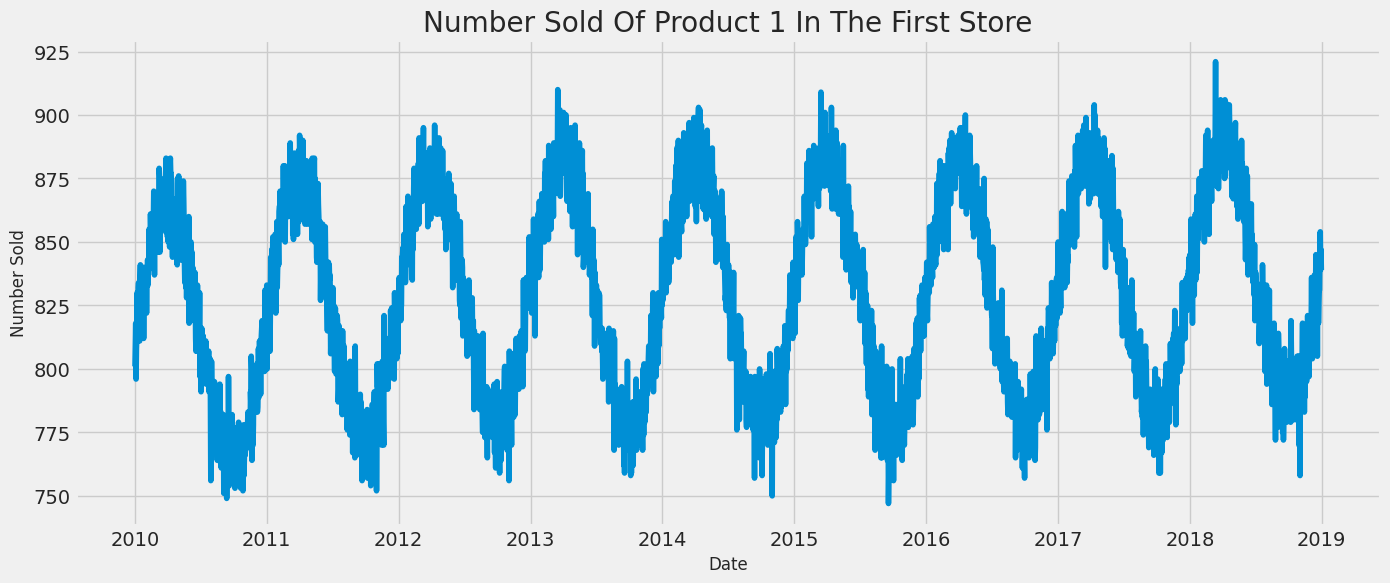

In [12]:
plt.figure(figsize = (15, 6))
plt.plot(s1p1.index, s1p1['number_sold'])
plt.xlabel('Date', {'fontsize': 12})
plt.ylabel('Number Sold', {'fontsize': 12})
plt.title('Number Sold Of Product 1 In The First Store')
plt.show()

_"number_sold"_ is our target

In [13]:
n_cols = 1
dataset = s1p1["number_sold"]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(3287, 1)

Let's rescale the values to make it easy for the model

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

Splitting data to train and test data to make training [75% to Train , 25% to Test]

In [15]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 2465 Test Size : 822


In [16]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(2465, 1)

LSTM takes a 3D input (num_samples, num_timesteps, num_features), so we will split data according that.

In [17]:
# Creating a Training set with 60 time-steps and 1 target
x_train = []
y_train = []
time_steps = 60
n_cols = 1

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :n_cols])
    y_train.append(train_data[i, :n_cols])
    if i<=time_steps:
        print('X_train: ', x_train)
        print('y_train:' , y_train)

X_train:  [array([[0.31034483],
       [0.36206897],
       [0.40804598],
       [0.2816092 ],
       [0.35057471],
       [0.37356322],
       [0.47701149],
       [0.37356322],
       [0.40229885],
       [0.48850575],
       [0.5       ],
       [0.45402299],
       [0.43103448],
       [0.36781609],
       [0.51149425],
       [0.54022989],
       [0.40804598],
       [0.45977011],
       [0.43103448],
       [0.40229885],
       [0.5       ],
       [0.44827586],
       [0.42528736],
       [0.53448276],
       [0.37356322],
       [0.50574713],
       [0.49425287],
       [0.49425287],
       [0.49425287],
       [0.53448276],
       [0.45402299],
       [0.50574713],
       [0.43103448],
       [0.49425287],
       [0.50574713],
       [0.55172414],
       [0.49425287],
       [0.52873563],
       [0.52873563],
       [0.62068966],
       [0.53448276],
       [0.5862069 ],
       [0.56321839],
       [0.65517241],
       [0.6091954 ],
       [0.55747126],
       [0.54597701],
  

In [18]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [19]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

In [20]:
x_train.shape , y_train.shape

((2405, 60, 1), (2405, 1))

# Model Structure

In [22]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

I train the model with train data for 100 epoch and batch_size = 32.

To avoid overfitting, I set an _EarlyStoping_ to stop training when "val_loss" has not improved after 10 epochs _(patience = 10).

In [24]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100


I0000 00:00:1732298442.791814   56217 cuda_dnn.cc:529] Loaded cuDNN version 90501


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0633 - mean_absolute_error: 0.1697
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - mean_absolute_error: 0.0543
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - mean_absolute_error: 0.0508
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0503
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - mean_absolute_error: 0.0505
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0511
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0484 
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0483
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0493
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0039 - mean_absolute_error: 0.0503
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/s

# Training Evaluation

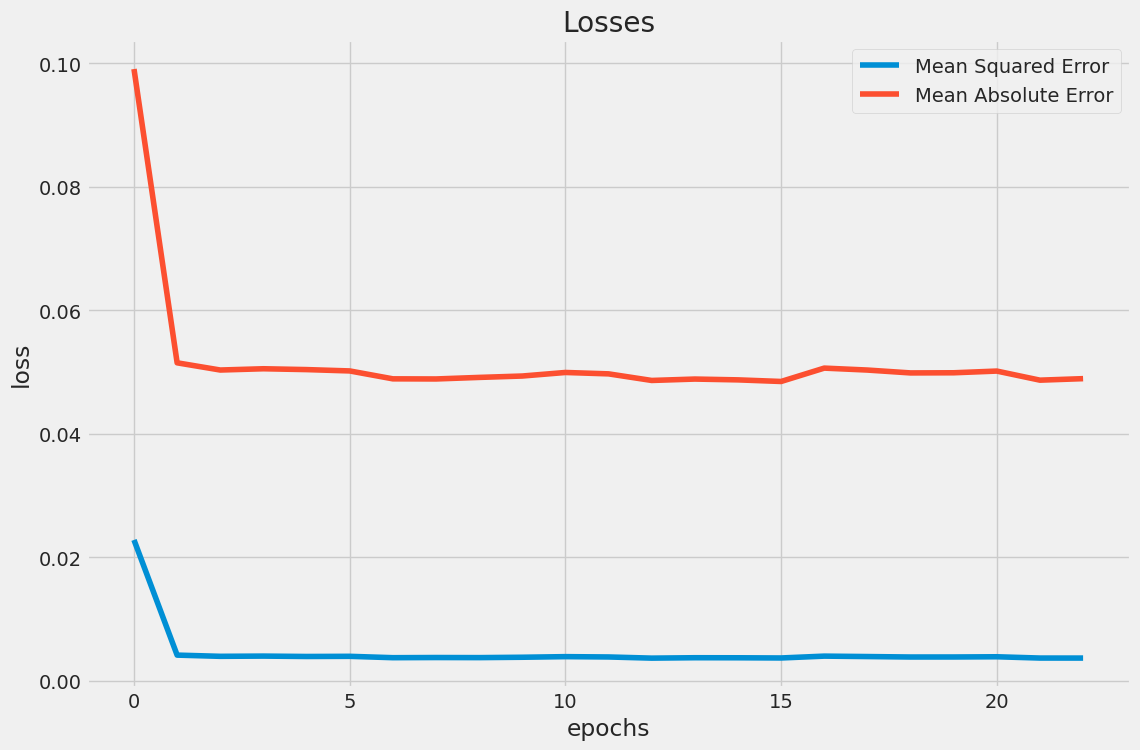

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Let's split test data to the same format (num_samples, num_timesteps, num_features)

In [26]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [26]:
x_test.shape , y_test.shape

((822, 60, 1), (822, 1))

### Get Prediction

In [27]:
predictions = model.predict(x_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [28]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(822, 1)

# Prediction Evaluation With Root Mean Square Error

In [29]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

np.float64(2.47)

In [30]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,775.520264,771.0
1,774.148743,773.0
2,773.261353,768.0
3,772.467773,770.0
4,771.883484,787.0
...,...,...
817,836.599060,847.0
818,837.752319,854.0
819,839.710083,839.0
820,841.294983,847.0


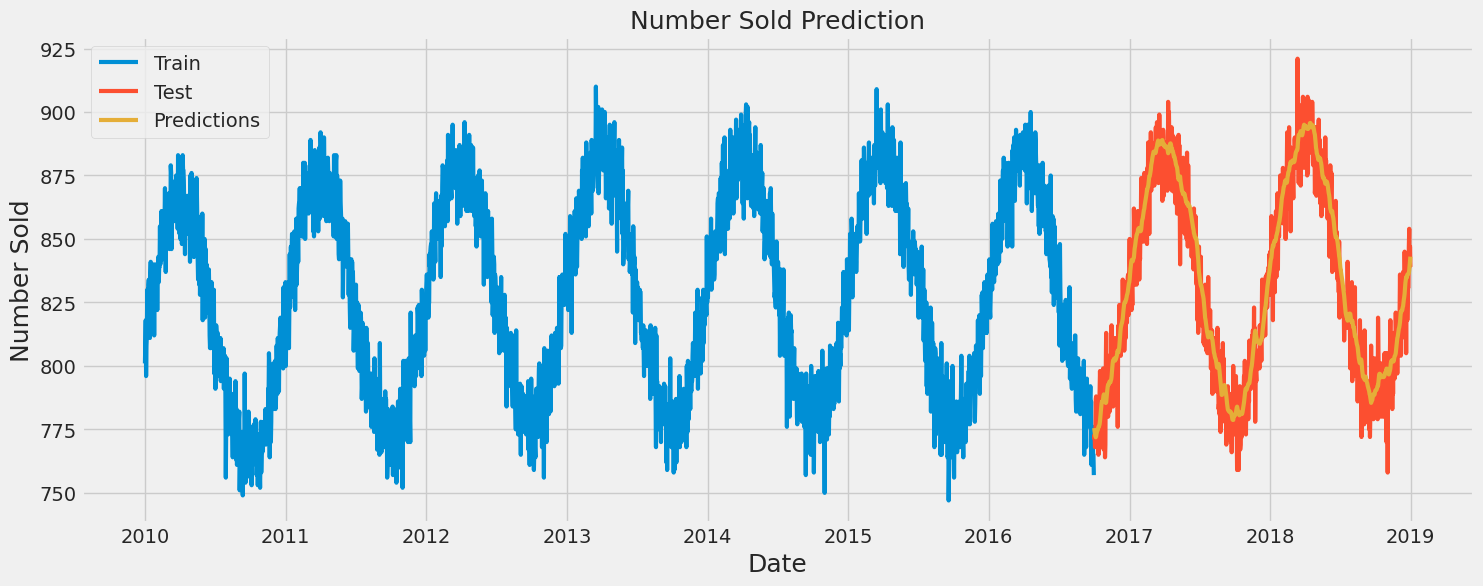

In [31]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Number Sold Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Number Sold', fontsize= 18)
plt.plot(train['number_sold'], linewidth= 3)
plt.plot(test['number_sold'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

# Forecast Next 60 Days

In [32]:
from datetime import timedelta

Function to store next value with old value

In [33]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

create time and forecasted data

In [34]:
future = 30 * 2
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(s1p1.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[np.float32(0.55196416)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[np.float32(0.55196416), np.float32(0.5606587)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[np.float32(0.55196416), np.float32(0.5606587), np.float32(0.5684697)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[np.float32(0.55196416), np.float32(0.5606587), np.float32(0.5684697), np.float32(0.5760623)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[np.float32(0.55196416), np.float32(0.5606587), np.float32(0.5684697), np.float32(0.5760623), np.float32(0.5833777)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[np.float32(0.55196416), np.float32(0.5606587), np.float32(0.5684697), np.float32(0.5760623), np.float32(0.5833777), np.float32(0.5905843)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[np.float32(0.55196416), np.float32(0.5606587), np.float32(0.5684697), np.float32(0.5760623), np.float32(0.5833777), np.float32(0.5905843), np.float32(0.59771794)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[np.float32(0.55196416), np.float32(0

In [35]:
time

[Timestamp('2018-12-31 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-01-02 00:00:00'),
 Timestamp('2019-01-03 00:00:00'),
 Timestamp('2019-01-04 00:00:00'),
 Timestamp('2019-01-05 00:00:00'),
 Timestamp('2019-01-06 00:00:00'),
 Timestamp('2019-01-07 00:00:00'),
 Timestamp('2019-01-08 00:00:00'),
 Timestamp('2019-01-09 00:00:00'),
 Timestamp('2019-01-10 00:00:00'),
 Timestamp('2019-01-11 00:00:00'),
 Timestamp('2019-01-12 00:00:00'),
 Timestamp('2019-01-13 00:00:00'),
 Timestamp('2019-01-14 00:00:00'),
 Timestamp('2019-01-15 00:00:00'),
 Timestamp('2019-01-16 00:00:00'),
 Timestamp('2019-01-17 00:00:00'),
 Timestamp('2019-01-18 00:00:00'),
 Timestamp('2019-01-19 00:00:00'),
 Timestamp('2019-01-20 00:00:00'),
 Timestamp('2019-01-21 00:00:00'),
 Timestamp('2019-01-22 00:00:00'),
 Timestamp('2019-01-23 00:00:00'),
 Timestamp('2019-01-24 00:00:00'),
 Timestamp('2019-01-25 00:00:00'),
 Timestamp('2019-01-26 00:00:00'),
 Timestamp('2019-01-27 00:00:00'),
 Timestamp('2019-01-

create _forecasted dataframe_

In [36]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [37]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

In [38]:
df_result

,Date,Forecasted
0,2018-12-31,843.041748
1,2019-01-01,844.554626
2,2019-01-02,845.913757
3,2019-01-03,847.234863
4,2019-01-04,848.507690
5,2019-01-05,849.761597
6,2019-01-06,851.002930
7,2019-01-07,852.235107
8,2019-01-08,853.475281
9,2019-01-09,854.721375


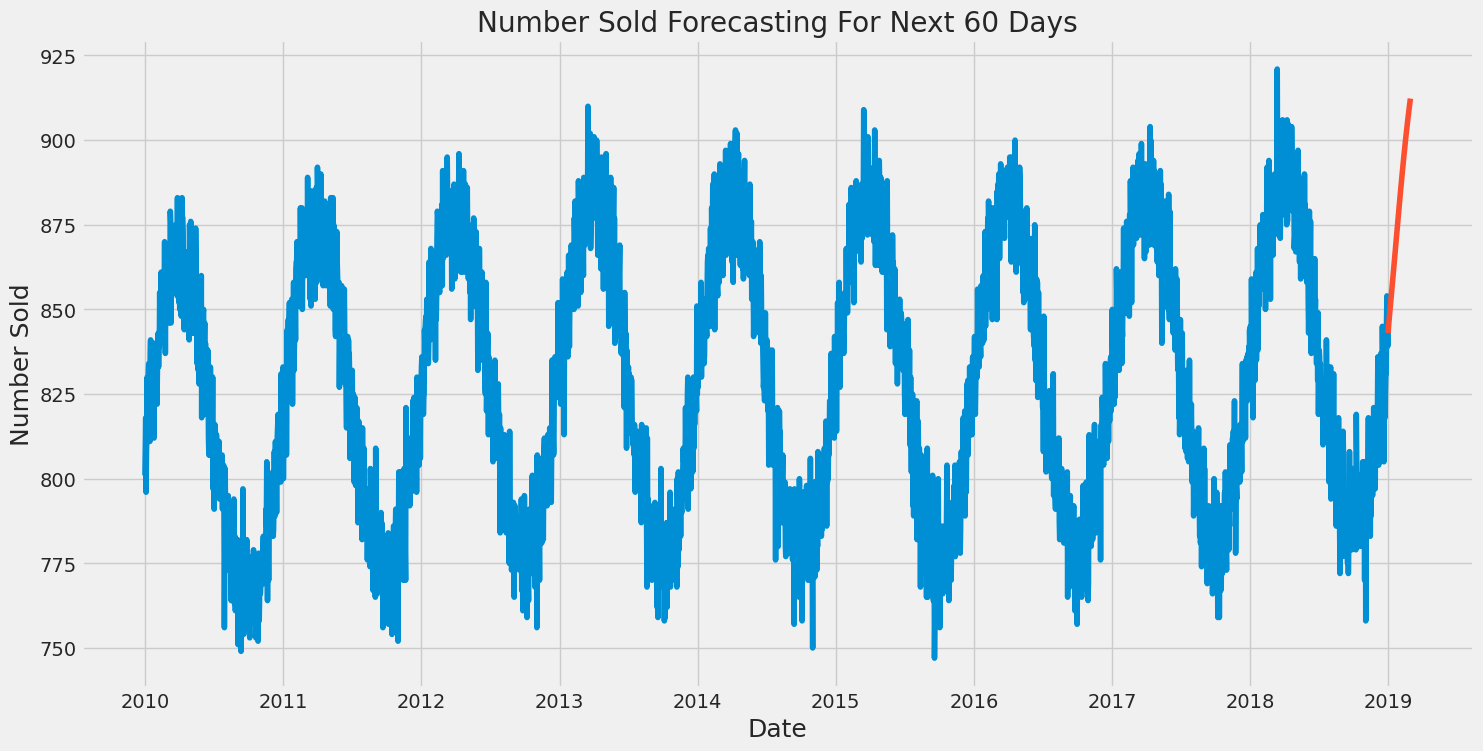

In [39]:
plt.figure(figsize=(16,8))
plt.title('Number Sold Forecasting For Next 60 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number Sold' ,fontsize=18)
plt.plot(s1p1['number_sold'])
plt.plot(df_result.set_index('Date')[['Forecasted']])

## 2nd Product
We will repeat the previous steps but in the data of product 2

In [40]:
# Store 1 with product 2
s1p2 = tr_df[(tr_df['store'] == 0) & (tr_df['product'] == 1)]
s1p2

,store,product,number_sold
Date,,,
2010-01-01,0,1,851
2010-01-02,0,1,843
2010-01-03,0,1,847
2010-01-04,0,1,855
2010-01-05,0,1,866
...,...,...,...
2018-12-27,0,1,708
2018-12-28,0,1,702
2018-12-29,0,1,698


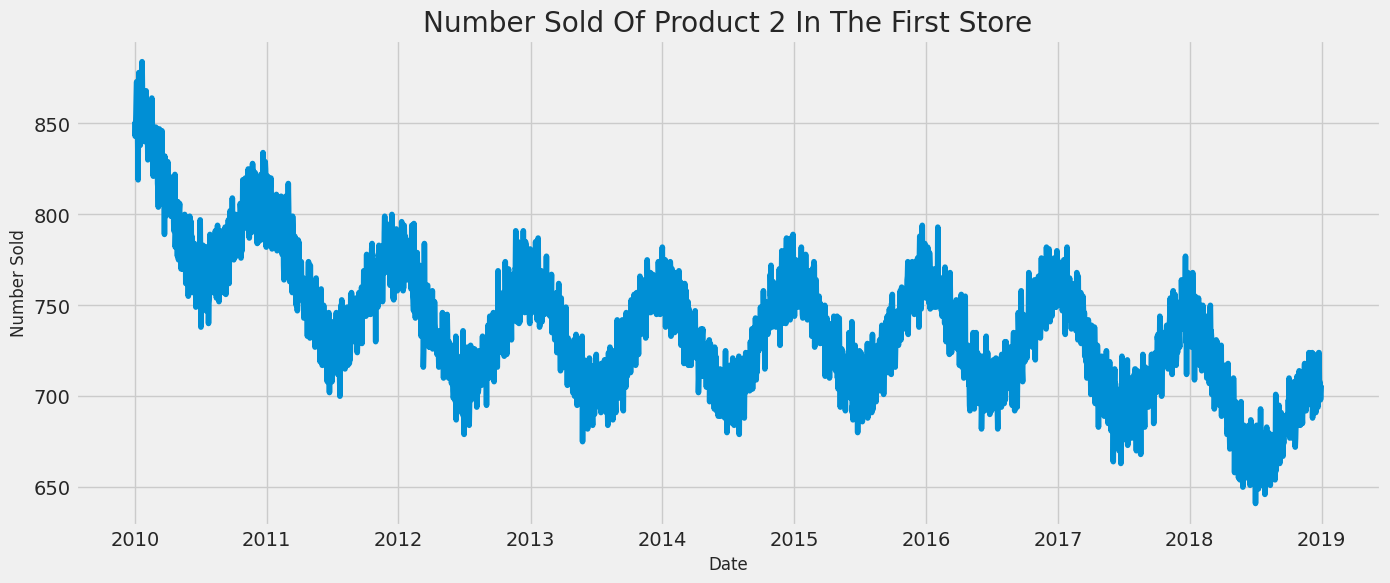

In [41]:
plt.figure(figsize = (15, 6))
plt.plot(s1p2.index, s1p2['number_sold'])
plt.xlabel('Date', {'fontsize': 12})
plt.ylabel('Number Sold', {'fontsize': 12})
plt.title('Number Sold Of Product 2 In The First Store')
plt.show()

In [42]:
n_cols = 1
dataset = s1p2["number_sold"]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(3287, 1)

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

In [44]:
# 75% to Train , 25% to Test
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 2465 Test Size : 822


In [45]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(2465, 1)

In [56]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []
time_steps = 120
n_cols = 1

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :n_cols])
    y_train.append(train_data[i, :n_cols])
    if i<=time_steps:
        print('X_train: ', x_train)
        print('y_train:' , y_train)

X_train:  [array([[0.86419753],
       [0.83127572],
       [0.84773663],
       [0.88065844],
       [0.92592593],
       [0.95473251],
       [0.86831276],
       [0.86419753],
       [0.81069959],
       [0.73251029],
       [0.89711934],
       [0.97530864],
       [0.9382716 ],
       [0.88065844],
       [0.87654321],
       [0.81069959],
       [0.85596708],
       [0.86419753],
       [0.86831276],
       [0.92592593],
       [1.        ],
       [0.93415638],
       [0.8436214 ],
       [0.88888889],
       [0.90946502],
       [0.86831276],
       [0.92592593],
       [0.82304527],
       [0.81893004],
       [0.8436214 ],
       [0.82304527],
       [0.93415638],
       [0.90946502],
       [0.86831276],
       [0.84773663],
       [0.84773663],
       [0.77777778],
       [0.85185185],
       [0.79012346],
       [0.89300412],
       [0.86419753],
       [0.86831276],
       [0.781893  ],
       [0.81893004],
       [0.90946502],
       [0.81069959],
       [0.86419753],
  

In [57]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))
x_train.shape , y_train.shape

((2345, 120, 1), (2345, 1))

In [58]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])
model.summary()

/home/lucasvillefort/Desktop/COURSE/SCIENCE_PROJECTS/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 120, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0273 - mean_absolute_error: 0.1151
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025 - mean_absolute_error: 0.0402
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026 - mean_absolute_error: 0.0405
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0027 - mean_absolute_error: 0.0414
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025 - mean_absolute_error: 0.0396
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - mean_absolute_error: 0.0413
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - mean_absolute_error: 0.0403
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - mean_absolute_error: 0.0409
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0025 - mean_absolute_error: 0.0405
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - mean_absolute_error: 0.0406
Epoch 11/100
74/74 ━━━━━━━━━━

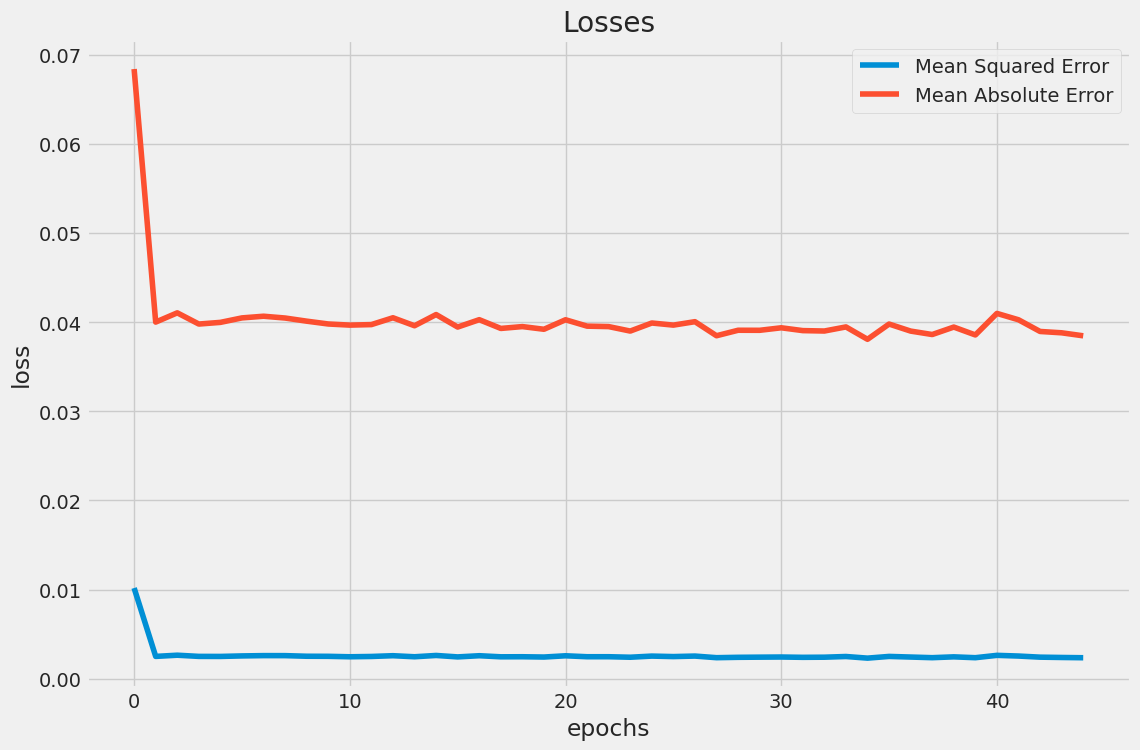

In [60]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [63]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 120
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

x_test.shape , y_test.shape

((822, 120, 1), (822, 1))

In [64]:
# Get Prediction
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


(822, 1)

In [65]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

np.float64(1.03)

In [66]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,730.106018,719.0
1,730.382629,740.0
2,730.901733,730.0
3,731.302246,731.0
4,731.703064,736.0
...,...,...
817,709.476807,708.0
818,709.799072,702.0
819,709.989258,698.0
820,710.064026,700.0


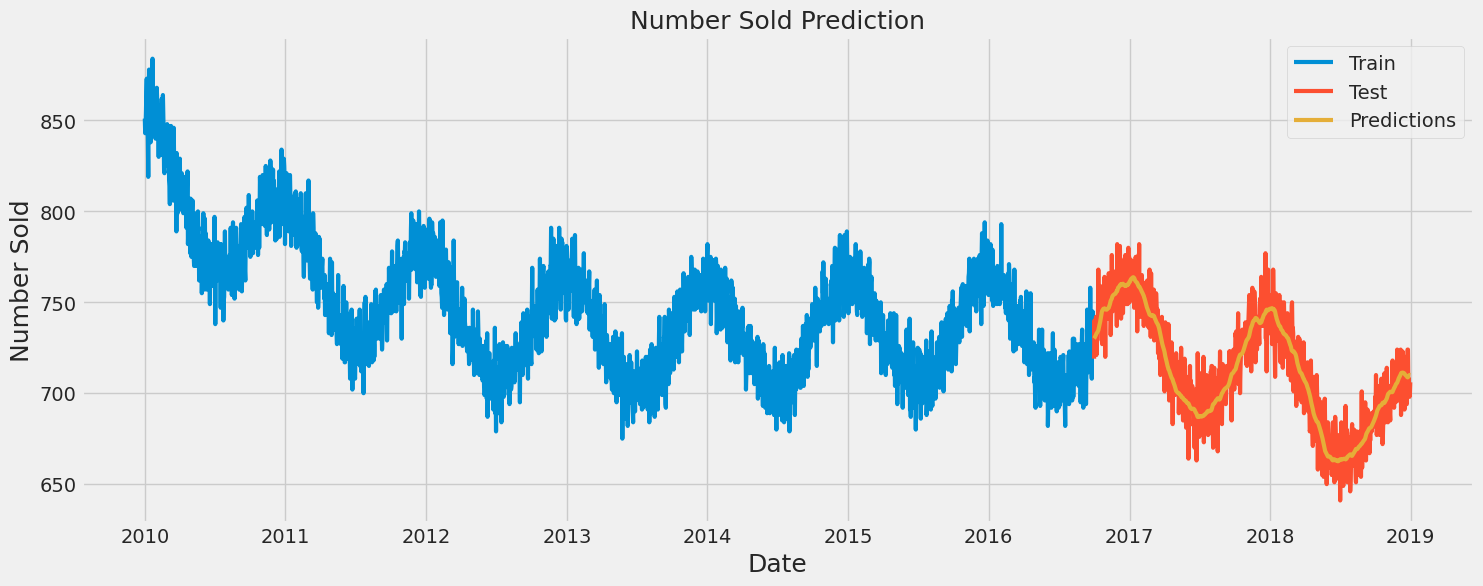

In [67]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Number Sold Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Number Sold', fontsize= 18)
plt.plot(train['number_sold'], linewidth= 3)
plt.plot(test['number_sold'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

In [68]:
from datetime import timedelta

In [70]:
def insert_end(Xin, new_input):
    timestep = 120
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [71]:
future = 30 * 4
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(s1p1.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[np.float32(0.28401965)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[np.float32(0.28401965), np.float32(0.2838776)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[np.float32(0.28401965), np.float32(0.2838776), np.float32(0.2838441)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[np.float32(0.28401965), np.float32(0.2838776), np.float32(0.2838441), np.float32(0.28382707)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[np.float32(0.28401965), np.float32(0.2838776), np.float32(0.2838441), np.float32(0.28382707), np.float32(0.28391367)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[np.float32(0.28401965), np.float32(0.2838776), np.float32(0.2838441), np.float32(0.28382707), np.float32(0.28391367), np.float32(0.28402746)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[np.float32(0.28401965), np.float32(0.2838776), np.float32(0.2838441), np.float32(0.28382707), np.float32(0.28391367), np.float32(0.28402746), np.float32(0.28417575)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[np.float32(0.28401965), np.

In [72]:
time

[Timestamp('2018-12-31 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-01-02 00:00:00'),
 Timestamp('2019-01-03 00:00:00'),
 Timestamp('2019-01-04 00:00:00'),
 Timestamp('2019-01-05 00:00:00'),
 Timestamp('2019-01-06 00:00:00'),
 Timestamp('2019-01-07 00:00:00'),
 Timestamp('2019-01-08 00:00:00'),
 Timestamp('2019-01-09 00:00:00'),
 Timestamp('2019-01-10 00:00:00'),
 Timestamp('2019-01-11 00:00:00'),
 Timestamp('2019-01-12 00:00:00'),
 Timestamp('2019-01-13 00:00:00'),
 Timestamp('2019-01-14 00:00:00'),
 Timestamp('2019-01-15 00:00:00'),
 Timestamp('2019-01-16 00:00:00'),
 Timestamp('2019-01-17 00:00:00'),
 Timestamp('2019-01-18 00:00:00'),
 Timestamp('2019-01-19 00:00:00'),
 Timestamp('2019-01-20 00:00:00'),
 Timestamp('2019-01-21 00:00:00'),
 Timestamp('2019-01-22 00:00:00'),
 Timestamp('2019-01-23 00:00:00'),
 Timestamp('2019-01-24 00:00:00'),
 Timestamp('2019-01-25 00:00:00'),
 Timestamp('2019-01-26 00:00:00'),
 Timestamp('2019-01-27 00:00:00'),
 Timestamp('2019-01-

In [73]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [74]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"
df_result

,Date,Forecasted
0,2018-12-31,710.016785
1,2019-01-01,709.982239
2,2019-01-02,709.974121
3,2019-01-03,709.969971
4,2019-01-04,709.991028
...,...,...
115,2019-04-25,712.349304
116,2019-04-26,712.198730
117,2019-04-27,712.046814
118,2019-04-28,711.888306


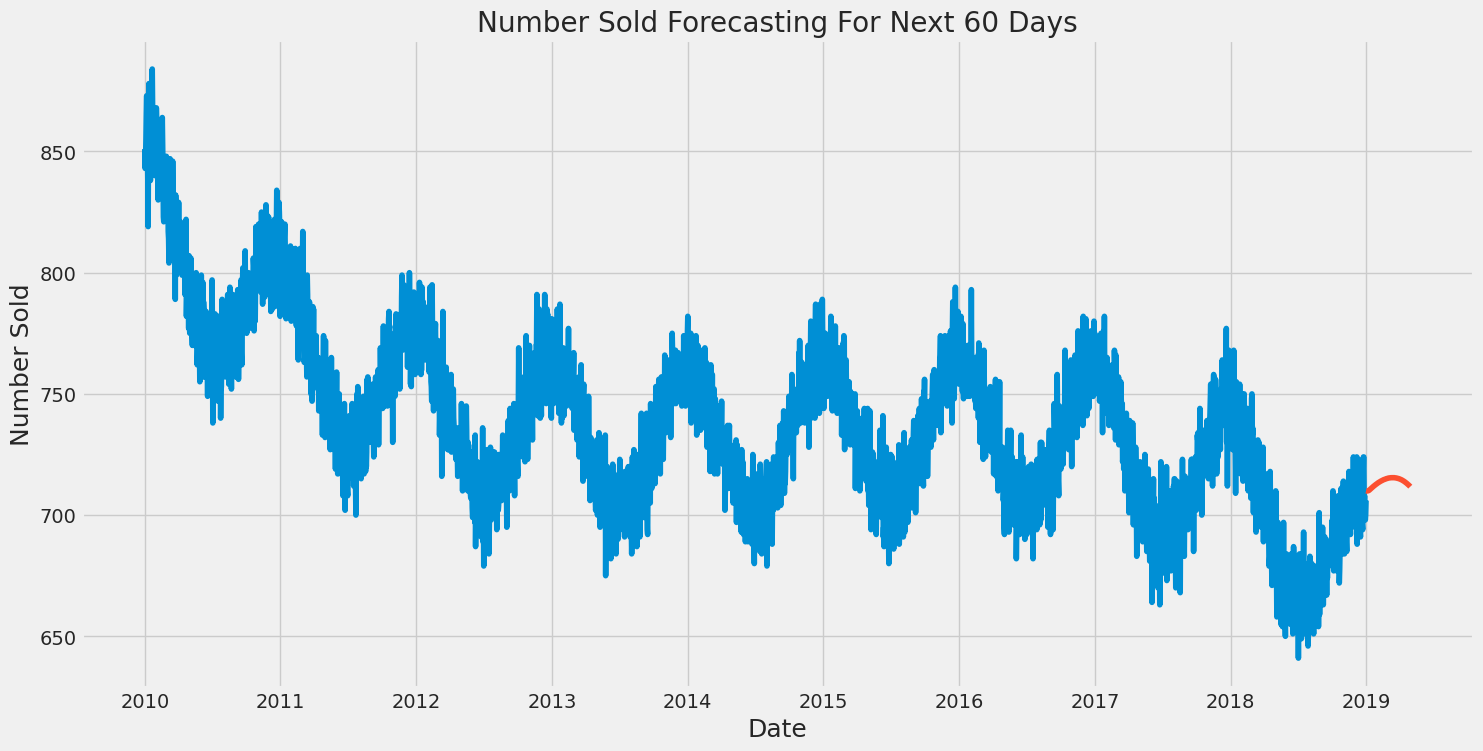

In [76]:
plt.figure(figsize=(16,8))
plt.title('Number Sold Forecasting For Next 60 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number Sold' ,fontsize=18)
plt.plot(s1p2['number_sold'])
plt.plot(df_result.set_index('Date')[['Forecasted']])

The next 120 days is not enough to show a good graph, so you can increase the time, but make sure that more needed days for forecasting, less accuracy will happen.

## 3rd Product

In [77]:
# Store 1 with product 3
s1p3 = tr_df[(tr_df['store'] == 0) & (tr_df['product'] == 2)]
s1p3

,store,product,number_sold
Date,,,
2010-01-01,0,2,893
2010-01-02,0,2,871
2010-01-03,0,2,862
2010-01-04,0,2,887
2010-01-05,0,2,891
...,...,...,...
2018-12-27,0,2,993
2018-12-28,0,2,986
2018-12-29,0,2,956


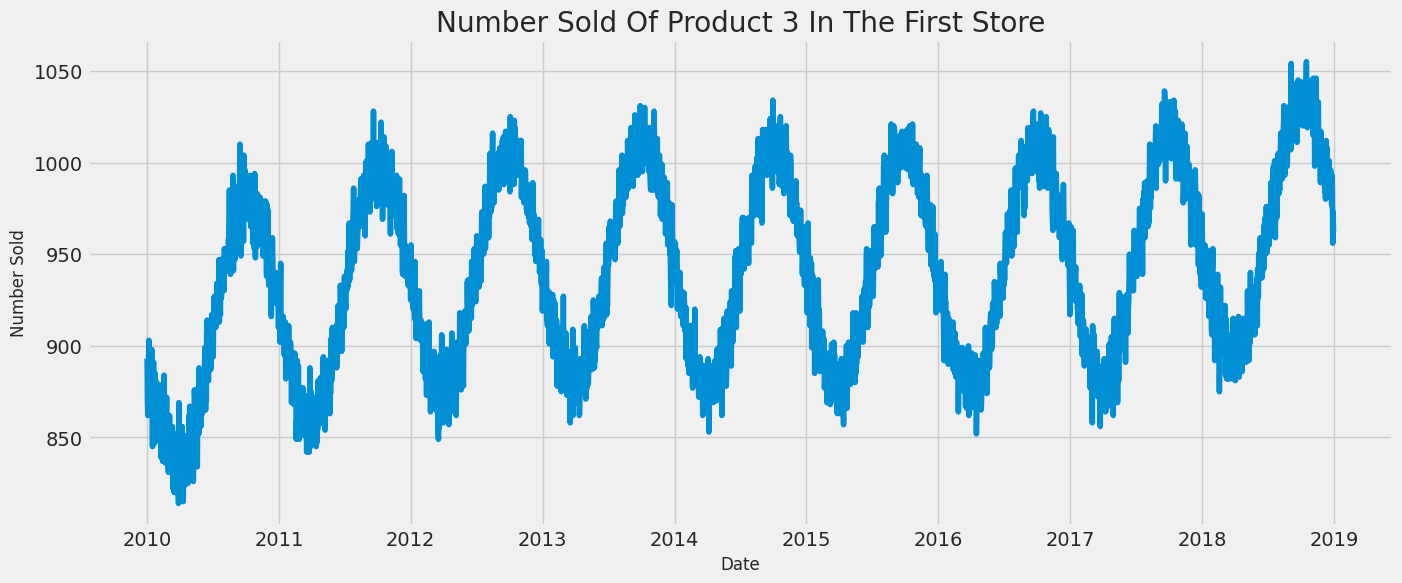

In [78]:
plt.figure(figsize = (15, 6))
plt.plot(s1p3.index, s1p3['number_sold'])
plt.xlabel('Date', {'fontsize': 12})
plt.ylabel('Number Sold', {'fontsize': 12})
plt.title('Number Sold Of Product 3 In The First Store')
plt.show()

In [79]:
n_cols = 1
dataset = s1p3["number_sold"]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(3287, 1)

In [80]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

In [81]:
# 75% to Train , 25% to Test
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[0:train_size, :]
train_data.shape

Train Size : 2465 Test Size : 822


(2465, 1)

In [121]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []
time_steps = 120
n_cols = 1

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :n_cols])
    y_train.append(train_data[i, :n_cols])
    if i<=time_steps:
        print('X_train: ', x_train)
        print('y_train:' , y_train)

X_train:  [array([[0.32780083],
       [0.23651452],
       [0.19917012],
       [0.30290456],
       [0.31950207],
       [0.36929461],
       [0.31950207],
       [0.2780083 ],
       [0.27385892],
       [0.32365145],
       [0.2780083 ],
       [0.25726141],
       [0.32365145],
       [0.34854772],
       [0.22821577],
       [0.12863071],
       [0.24481328],
       [0.30705394],
       [0.31950207],
       [0.26556017],
       [0.26970954],
       [0.13692946],
       [0.29460581],
       [0.17427386],
       [0.2780083 ],
       [0.2406639 ],
       [0.21991701],
       [0.26556017],
       [0.1659751 ],
       [0.19917012],
       [0.17427386],
       [0.17427386],
       [0.26970954],
       [0.22406639],
       [0.18672199],
       [0.14522822],
       [0.14937759],
       [0.13692946],
       [0.17842324],
       [0.10373444],
       [0.19087137],
       [0.15352697],
       [0.1659751 ],
       [0.09543568],
       [0.09543568],
       [0.17842324],
       [0.18257261],
  

In [122]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))
x_train.shape , y_train.shape

((2345, 120, 1), (2345, 1))

In [123]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])
model.summary()

/home/lucasvillefort/Desktop/COURSE/SCIENCE_PROJECTS/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 120, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0611 - mean_absolute_error: 0.1612
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0414
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mean_absolute_error: 0.0431
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - mean_absolute_error: 0.0397
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - mean_absolute_error: 0.0400
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0026 - mean_absolute_error: 0.0409
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0024 - mean_absolute_error: 0.0389
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025 - mean_absolute_error: 0.0403
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0025 - mean_absolute_error: 0.0403
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - mean_absolute_error: 0.0399
Epoch 11/100
74/74 ━━━━━━━━━━

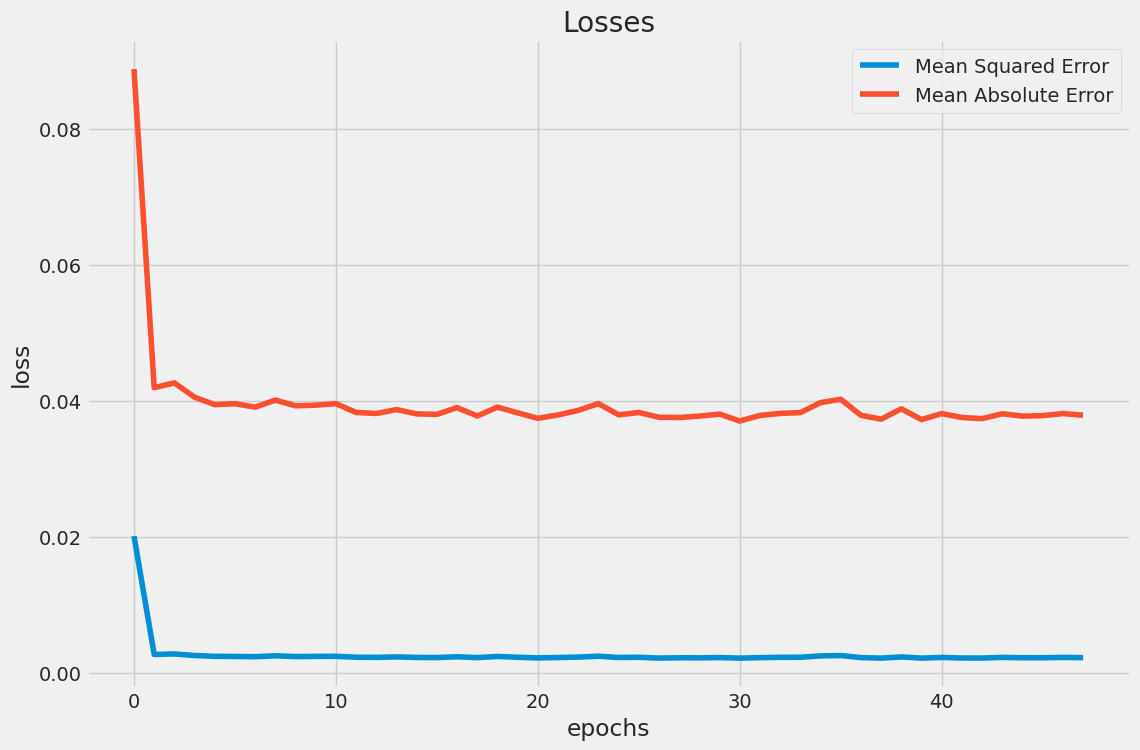

In [125]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [126]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 120
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

x_test.shape , y_test.shape

((822, 120, 1), (822, 1))

In [127]:
# Get Prediction
predictions = model.predict(x_test)
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


(822, 1)

In [128]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

np.float64(5.9)

In [129]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,1000.959167,995.0
1,999.944214,1004.0
2,999.281677,1006.0
3,998.776306,1021.0
4,999.038452,1007.0
...,...,...
817,970.776672,993.0
818,970.613159,986.0
819,970.293213,956.0
820,968.519165,973.0


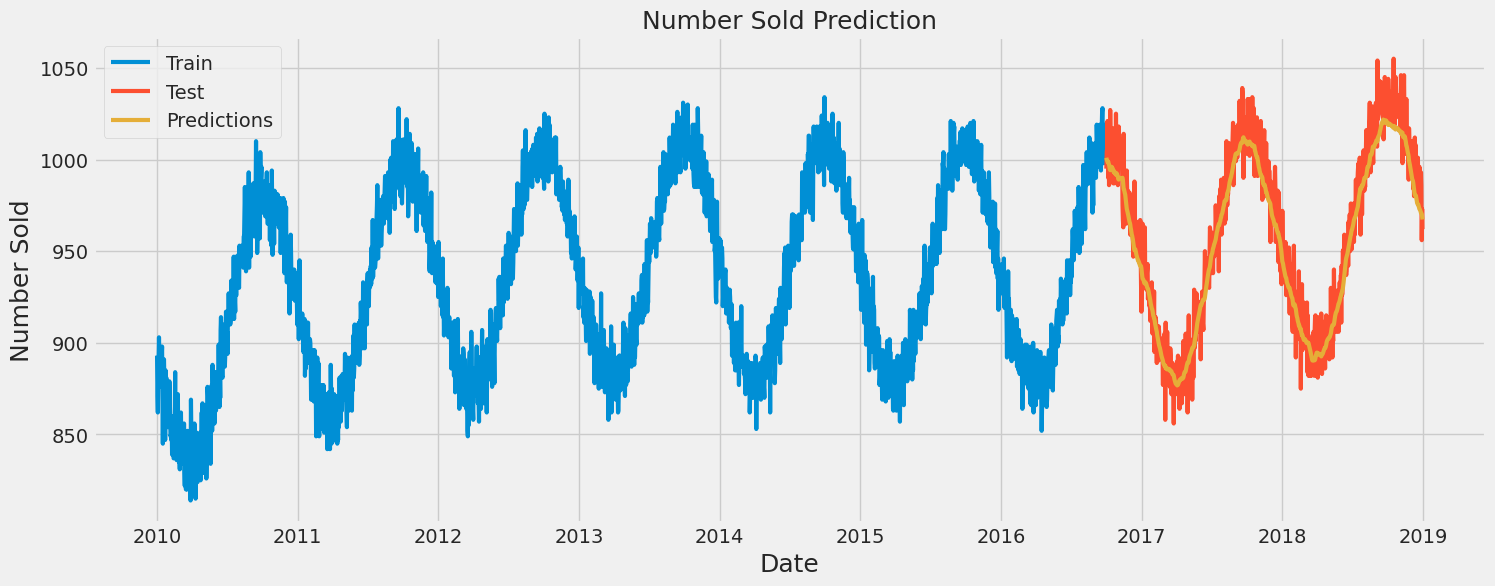

In [130]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Number Sold Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Number Sold', fontsize= 18)
plt.plot(train['number_sold'], linewidth= 3)
plt.plot(test['number_sold'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

In [131]:
from datetime import timedelta

In [134]:
def insert_end(Xin, new_input):
    timestep = 120
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [135]:
future = 120
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(s1p1.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[np.float32(0.63094866)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[np.float32(0.63094866), np.float32(0.6247959)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[np.float32(0.63094866), np.float32(0.6247959), np.float32(0.6182875)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[np.float32(0.63094866), np.float32(0.6247959), np.float32(0.6182875), np.float32(0.61148494)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[np.float32(0.63094866), np.float32(0.6247959), np.float32(0.6182875), np.float32(0.61148494), np.float32(0.604456)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[np.float32(0.63094866), np.float32(0.6247959), np.float32(0.6182875), np.float32(0.61148494), np.float32(0.604456), np.float32(0.5972305)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[np.float32(0.63094866), np.float32(0.6247959), np.float32(0.6182875), np.float32(0.61148494), np.float32(0.604456), np.float32(0.5972305), np.float32(0.5898314)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[np.float32(0.63094866), np.float32(0

In [136]:
time

[Timestamp('2018-12-31 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-01-02 00:00:00'),
 Timestamp('2019-01-03 00:00:00'),
 Timestamp('2019-01-04 00:00:00'),
 Timestamp('2019-01-05 00:00:00'),
 Timestamp('2019-01-06 00:00:00'),
 Timestamp('2019-01-07 00:00:00'),
 Timestamp('2019-01-08 00:00:00'),
 Timestamp('2019-01-09 00:00:00'),
 Timestamp('2019-01-10 00:00:00'),
 Timestamp('2019-01-11 00:00:00'),
 Timestamp('2019-01-12 00:00:00'),
 Timestamp('2019-01-13 00:00:00'),
 Timestamp('2019-01-14 00:00:00'),
 Timestamp('2019-01-15 00:00:00'),
 Timestamp('2019-01-16 00:00:00'),
 Timestamp('2019-01-17 00:00:00'),
 Timestamp('2019-01-18 00:00:00'),
 Timestamp('2019-01-19 00:00:00'),
 Timestamp('2019-01-20 00:00:00'),
 Timestamp('2019-01-21 00:00:00'),
 Timestamp('2019-01-22 00:00:00'),
 Timestamp('2019-01-23 00:00:00'),
 Timestamp('2019-01-24 00:00:00'),
 Timestamp('2019-01-25 00:00:00'),
 Timestamp('2019-01-26 00:00:00'),
 Timestamp('2019-01-27 00:00:00'),
 Timestamp('2019-01-

In [137]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [138]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"
df_result

,Date,Forecasted
0,2018-12-31,966.058655
1,2019-01-01,964.575867
2,2019-01-02,963.007263
3,2019-01-03,961.367859
4,2019-01-04,959.673950
...,...,...
115,2019-04-25,855.364746
116,2019-04-26,856.509583
117,2019-04-27,857.683350
118,2019-04-28,858.885742


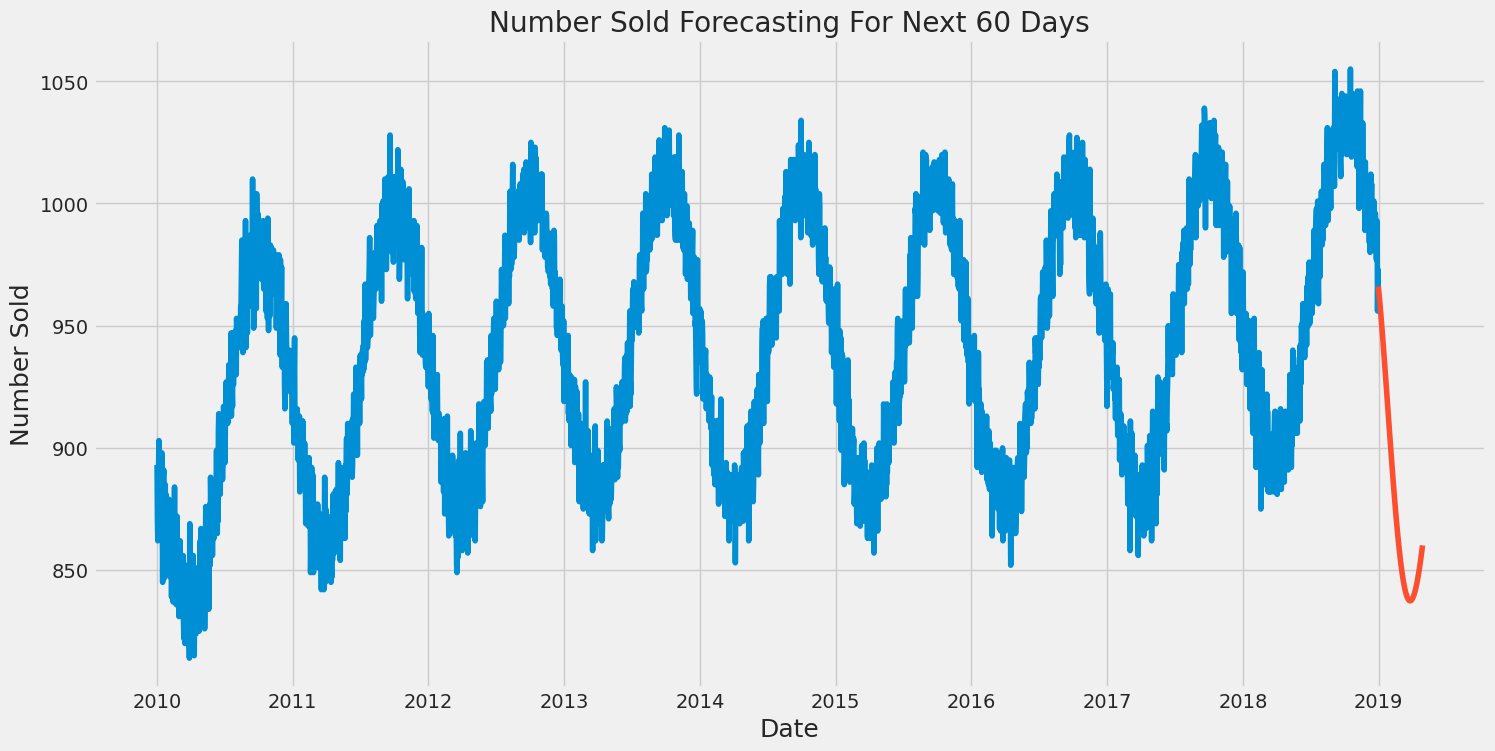

In [139]:
plt.figure(figsize=(16,8))
plt.title('Number Sold Forecasting For Next 60 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number Sold' ,fontsize=18)
plt.plot(s1p3['number_sold'])
plt.plot(df_result.set_index('Date')[['Forecasted']])

## It will take a time to try all the data ! If you want to do that, you won't find any error but take care when you chose the product data..

## If you find this notebook make sense, please upvote it and follow me.
## THANK YOU..